In [1]:
import torch
import numpy as np 
import pandas as pd
import PIL

In [2]:
torch.cuda.is_available()

True

In [3]:
PIL.PILLOW_VERSION

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  """Entry point for launching an IPython kernel.


'7.1.2'

In [4]:
from google.colab import drive

In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
! ls /content/gdrive/

MyDrive  Shareddrives


In [8]:
!unzip -q /content/gdrive/MyDrive/intel_image.zip -d seg_train
!unzip -q /content/gdrive/MyDrive/intel_image.zip -d seg_test

In [9]:
!ls seg_train

seg_pred  seg_test  seg_train


In [10]:
pip install alive_progress 

In [11]:
import pickle 

from skimage import io
from PIL import Image
from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from sklearn.model_selection import train_test_split
from alive_progress import alive_bar
from tqdm import tqdm, tqdm_notebook
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [12]:
data_mode = ['train', 'test', 'val']
image_size = 100
device = torch.device('cuda')

In [13]:
class ImageDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        #list of files for loading
        self.files = sorted(files)
        # working mode 
        self.mode = mode

        if self.mode not in data_mode:
            print(f"{self.mode} is not correct; correct modes: {data_mode}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        #for transform pictures into pytorch tensors and normilize 
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((image_size, image_size))
        return np.array(image)

In [14]:
def imshow(inp, title=None, plt_ax=plt, default=False):
  """
  inshow for pytorch tensors 
  """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [15]:
train_dir = Path('seg_train/seg_train/seg_train')
test_dir = Path('seg_train/seg_test/seg_test')

In [16]:
train_val_files = sorted(list(train_dir.rglob('*.jpg')))
test_files = sorted(list(test_dir.rglob('*.jpg')))

In [17]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files,test_size=0.25, stratify=train_val_labels)

In [18]:
val_dataset = ImageDataset(val_files,mode='val')

In [19]:
def plot_gal(n_rows,n_cols, dataset):
  fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(8, 8), sharey=True, sharex=True)
  for fig_x in ax.flatten():
    random_image = int(np.random.uniform(0,len(dataset)))
    im_val, label = dataset[random_image]
    img_label = " ".join(map(lambda x: x.capitalize(), dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

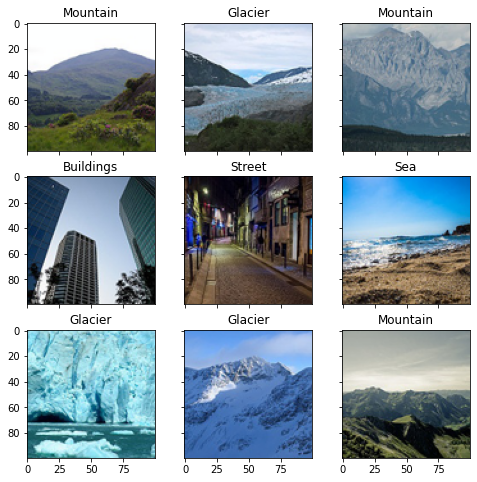

In [20]:
plot_gal(3,3,val_dataset)

# Fit and eval

In [21]:
def fit_epoch(model, train_loader, criterion, optimizer,DEVICE=device):
  """
  training of one single epoch
  """
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [22]:
def eval_epoch(model, val_loader, criterion,DEVICE=device):
  """
  evaluation of single epoch
  """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [30]:
def train(train_files, val_files, model, epochs, batch_size,opt):
  """
  training of all epochs
  """
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [24]:
def predict(model, test_loader):
  """
  function to predict results
  """
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [25]:
n_classes = len(np.unique(train_val_labels))

In [26]:
resnet_model = models.resnet50(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


In [27]:
train_dataset = ImageDataset(train_files,mode='train')
print(len(train_dataset))

10525


In [31]:
resnet_history = train(train_dataset,val_dataset,resnet_model,10,256,torch.optim.Adam(resnet_model.parameters(),lr=1e-4))

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.4401797631135179


epoch:  10%|█         | 1/10 [00:52<07:56, 52.94s/it]


Epoch 001 train_loss: 0.4402     val_loss 0.2476 train_acc 0.8794 val_acc 0.9114
loss 0.15722574060043926


epoch:  20%|██        | 2/10 [01:46<07:03, 52.98s/it]


Epoch 002 train_loss: 0.1572     val_loss 0.2365 train_acc 0.9452 val_acc 0.9233
loss 0.09214448317637636


epoch:  30%|███       | 3/10 [02:39<06:11, 53.07s/it]


Epoch 003 train_loss: 0.0921     val_loss 0.2627 train_acc 0.9698 val_acc 0.9139
loss 0.057077349534616614


epoch:  40%|████      | 4/10 [03:32<05:19, 53.22s/it]


Epoch 004 train_loss: 0.0571     val_loss 0.3258 train_acc 0.9809 val_acc 0.9102
loss 0.06777930735975433


epoch:  50%|█████     | 5/10 [04:26<04:26, 53.28s/it]


Epoch 005 train_loss: 0.0678     val_loss 0.3445 train_acc 0.9749 val_acc 0.9194
loss 0.0683285458247905


epoch:  60%|██████    | 6/10 [05:19<03:33, 53.36s/it]


Epoch 006 train_loss: 0.0683     val_loss 0.3407 train_acc 0.9766 val_acc 0.9099
loss 0.021980758891164406


epoch:  70%|███████   | 7/10 [06:13<02:40, 53.43s/it]


Epoch 007 train_loss: 0.0220     val_loss 0.3666 train_acc 0.9931 val_acc 0.9154
loss 0.041654425082714996


epoch:  80%|████████  | 8/10 [07:07<01:46, 53.48s/it]


Epoch 008 train_loss: 0.0417     val_loss 0.3443 train_acc 0.9843 val_acc 0.9151
loss 0.024478451084310186


epoch:  90%|█████████ | 9/10 [08:00<00:53, 53.55s/it]


Epoch 009 train_loss: 0.0245     val_loss 0.4023 train_acc 0.9915 val_acc 0.9162
loss 0.014352508433640995


epoch: 100%|██████████| 10/10 [08:52<00:00, 53.26s/it]


Epoch 010 train_loss: 0.0144     val_loss 0.4656 train_acc 0.9951 val_acc 0.9020


In [ ]:
#let's draw history of training 

In [32]:
def draw_history(history):
  loss, acc, val_loss, val_acc = zip(*history)
  plt.figure(figsize=(15, 9))
  plt.plot(loss, label="train_loss")
  plt.plot(val_loss, label="val_loss")
  plt.legend(loc='best')
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.show()

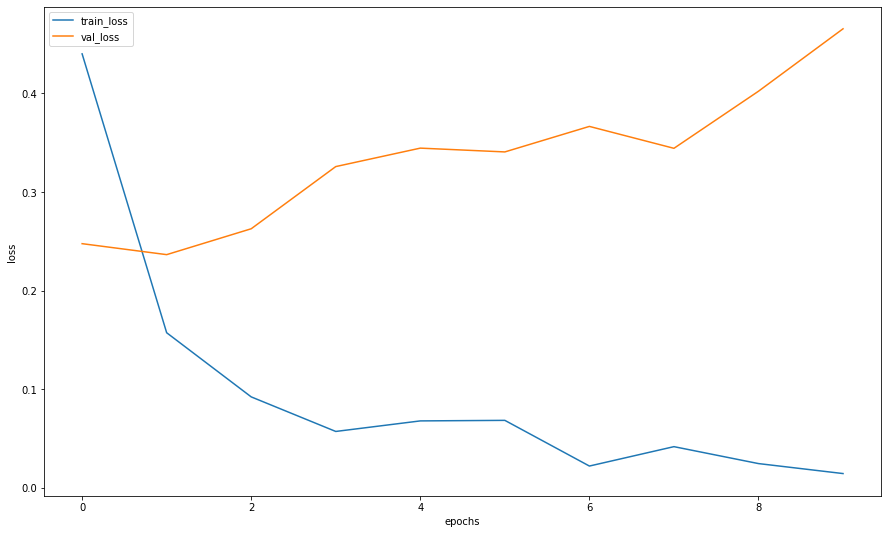

In [33]:
draw_history(resnet_history)

In [ ]:
#looks like overfitting((